In [316]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import numpy.random as npr
import seaborn as sns
from collections import defaultdict

import os

import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms
import torch.distributions.constraints as constraints
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pyro
from pyro.contrib.examples.util import print_and_log
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam, SGD

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

USE_CUDA = True

pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

# Defining VAE model

In [2]:
class Encoder(nn.Module):
    def __init__(self, image_dim, label_dim, z_dim):
        super(Encoder, self).__init__()
        self.image_dim = image_dim
        self.label_dim = label_dim
        self.z_dim = z_dim
        # setup the three linear transformations used
        self.fc1 = nn.Linear(self.image_dim+self.label_dim, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc31 = nn.Linear(1000, z_dim)  # mu values
        self.fc32 = nn.Linear(1000, z_dim)  # sigma values
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, xs, ys):
        # define the forward computation on the image xs and label ys
        # first shape the mini-batch to have pixels in the rightmost dimension
        xs = xs.reshape(-1, self.image_dim)
        #now concatenate the image and label
        inputs = torch.cat((xs,ys), -1)
        # then compute the hidden units
        hidden1 = self.softplus(self.fc1(inputs))
        hidden2 = self.softplus(self.fc2(hidden1))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc31(hidden2)
        z_scale = torch.exp(self.fc32(hidden2))
        return z_loc, z_scale
    
class Decoder(nn.Module):
    def __init__(self, image_dim, label_dim, z_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        hidden_dim = 1000
        self.fc1 = nn.Linear(z_dim+label_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, image_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, zs, ys):
        # define the forward computation on the latent z and label y
        # first concatenate z and y
        inputs = torch.cat((zs, ys),-1)
        # then compute the hidden units
        hidden1 = self.softplus(self.fc1(inputs))
        hidden2 = self.softplus(self.fc2(hidden1))
        hidden3 = self.softplus(self.fc3(hidden2))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc4(hidden3))
        return loc_img

In [3]:
class CVAE(nn.Module):

    def __init__(self, config_enum=None, use_cuda=False, aux_loss_multiplier=None):

        super(CVAE, self).__init__()
    
        self.image_dim = 64**2
        self.label_shape = np.array((1,3,6,40,32,32))
        self.label_names = np.array(('color', 'shape', 'scale', 'orientation', 'posX', 'posY'))
        self.label_dim = np.sum(self.label_shape)
        self.z_dim = 50                                    
        self.use_cuda = use_cuda

        # define and instantiate the neural networks representing
        # the paramters of various distributions in the model
        self.setup_networks()

    def setup_networks(self):
        self.encoder = Encoder(self.image_dim, self.label_dim, self.z_dim)

        self.decoder = Decoder(self.image_dim, self.label_dim, self.z_dim)

        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()

    def model(self, xs, ys):
        """
        The model corresponds to the following generative process:
        p(z) = normal(0,I)              # dsprites label (latent)
        p(x|y,z) = bernoulli(loc(y,z))   # an image
        loc is given by a neural network  `decoder`

        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("cvae", self)

        batch_size = xs.size(0)
        options = dict(dtype=xs.dtype, device=xs.device)
        with pyro.plate("data"):

            prior_loc = torch.zeros(batch_size, self.z_dim, **options)
            prior_scale = torch.ones(batch_size, self.z_dim, **options)
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))
            
            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
    
            loc = self.decoder.forward(zs, self.remap_y(ys))
            pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
            # return the loc so we can visualize it later
            return loc

    def guide(self, xs, ys):
        """
        The guide corresponds to the following:
        q(z|x,y) = normal(loc(x,y),scale(x,y))       # infer latent class from an image and the label 
        loc, scale are given by a neural network `encoder`

        :param xs: a batch of scaled vectors of pixels from an image
        :return: None
        """
        # inform Pyro that the variables in the batch of xs are conditionally independent
        with pyro.plate("data"):
            # sample (and score) the latent handwriting-style with the variational
            # distribution q(z|x) = normal(loc(x),scale(x))
    
            loc, scale = self.encoder.forward(xs, self.remap_y(ys))
            pyro.sample("z", dist.Normal(loc, scale).to_event(1))
            
    def remap_y(self, ys):
        new_ys = []
        options = dict(dtype=ys.dtype, device=ys.device)
        for i, label_length in enumerate(self.label_shape):
            prior = torch.ones(ys.size(0), label_length, **options) / (1.0 * label_length)
            new_ys.append(pyro.sample("y_%s" % self.label_names[i], dist.OneHotCategorical(prior), 
                                   obs=torch.nn.functional.one_hot(ys[:,i].to(torch.int64), int(label_length))))
        new_ys = torch.cat(new_ys, -1)
        return new_ys.to(torch.float32)
            
    def reconstruct_image(self, xs, ys):
        # backward
        sim_z_loc, sim_z_scale = self.encoder.forward(xs, self.remap_y(ys))
        zs = dist.Normal(sim_z_loc, sim_z_scale).to_event(1).sample()
        # forward
        loc = self.decoder.forward(zs, self.remap_y(ys))
        return dist.Bernoulli(loc).to_event(1).sample()


# Loading and Visualizing Data

In [4]:
def setup_data_loaders(train_x, test_x, train_y, test_y, batch_size=128, use_cuda=False):
    train_dset = torch.utils.data.TensorDataset(
        torch.from_numpy(train_x.astype(np.float32)).reshape(-1, 4096),
        torch.from_numpy(train_y.astype(np.float32))
    )
    
    test_dset = torch.utils.data.TensorDataset(
        torch.from_numpy(test_x.astype(np.float32)).reshape(-1, 4096),
        torch.from_numpy(test_y.astype(np.float32))
    )    
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dset, batch_size=batch_size, shuffle=False, **kwargs
    )
    
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dset, batch_size=batch_size, shuffle=False, **kwargs
    )
    
    return {"train":train_loader, "test":test_loader}

In [5]:
dataset_zip = np.load(
    'dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',
    encoding = 'bytes',
    allow_pickle=True
)
imgs = dataset_zip['imgs']
labels = dataset_zip['latents_classes']
label_sizes = dataset_zip['metadata'][()][b'latents_sizes']
label_names = dataset_zip['metadata'][()][b'latents_names']

# Sample imgs randomly
indices_sampled = np.arange(imgs.shape[0])
np.random.shuffle(indices_sampled)
imgs_sampled = imgs[indices_sampled]
labels_sampled = labels[indices_sampled]

data_loaders = setup_data_loaders(
    imgs_sampled[1000:],
    imgs_sampled[:1000],
    labels_sampled[1000:],
    labels_sampled[:1000],
    batch_size=256,
    use_cuda=USE_CUDA
)


In [6]:
y_names = ['shape', 'scale', 'orientation', 'posX', 'posY']
y_shapes = np.array((3,6,40,32,32))
img_dict = {}
for i, img in enumerate(imgs_sampled):
    img_dict[tuple(labels_sampled[i])] = img
    
def find_in_dataset(shape, scale, orient, posX, posY):
    fig = plt.figure()
    img = img_dict[(0, shape, scale, orient, posX, posY)]
    plt.imshow(img.reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    
interact(find_in_dataset, shape=widgets.IntSlider(min=0, max=2, step=1, value=npr.randint(2)),
                          scale=widgets.IntSlider(min=0, max=5, step=1, value=npr.randint(5)),
                            orient=widgets.IntSlider(min=0, max=39, step=1, value=npr.randint(39)),
                            posX=widgets.IntSlider(min=0, max=31, step=1, value=npr.randint(31)),
                            posY=widgets.IntSlider(min=0, max=31, step=1, value=npr.randint(31)))

interactive(children=(IntSlider(value=0, description='shape', max=2), IntSlider(value=4, description='scale', …

<function __main__.find_in_dataset(shape, scale, orient, posX, posY)>

## Helper functions for visualizing data

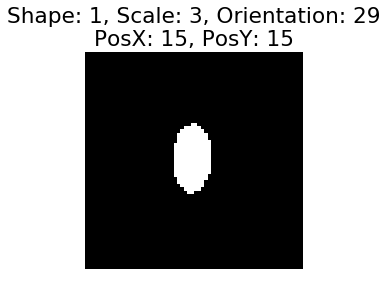

In [7]:
def get_specific_data(args=dict(), cuda=False):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        cuda - bool to indicate whether the output should be placed on GPU
    '''
    names_dict = {'shape': 1, 'scale': 2, 'orientation': 3, 'posX': 4, 'posY': 5}
    selected_ind = np.ones(imgs.shape[0], dtype=bool)
    for k,v in args.items():
        col_id = names_dict[k]
        selected_ind = np.bitwise_and(selected_ind, labels[:, col_id] == v)
    ind = np.random.choice(np.arange(imgs.shape[0])[selected_ind])
    x = torch.from_numpy(imgs[ind].reshape(1,64**2).astype(np.float32))
    y = torch.from_numpy(labels[ind].reshape(1,6).astype(np.float32))
    if not cuda:
        return x,y
    x = x.cuda()
    y = y.cuda()
    return x,y

def plot_image(x):
    x = x.cpu()
    plt.figure()
    plt.imshow(x.reshape(64,64), interpolation='nearest', cmap='Greys_r')
    plt.axis('off')

def see_specific_image(args=dict(), verbose=True):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        verbose - bool to indicate whether the full class label should be written 
                    as the title of the plot
    '''
    x,y = get_specific_data(args, cuda=False)
    plot_image(x)
    if verbose:
        string = ''
        for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
            string += '%s: %d, ' % (s, int(y[0][i+1]))
            if i == 2:
                string = string[:-2] + '\n'
        plt.title(string[:-2])
        
def compare_reconstruction(original, recon):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array for recon image
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(recon.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstruction')
    
def compare_to_density(original, recons):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array of multiple recon images
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(torch.mean(recons.cpu(), 0).reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstructions')

        
see_specific_image()

# Training or Loading the Model

In [8]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for xs,ys in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            xs = xs.cuda()
            ys = ys.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(xs, ys)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for xs, ys in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            xs = xs.cuda()
            ys = ys.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(xs, ys)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [9]:
# Run options
LEARNING_RATE = 1.0e-3

# Run only for a single iteration for testing
NUM_EPOCHS = 0
TEST_FREQUENCY = 5

In [10]:
#################################
### FOR SAVING AND LOADING MODEL
################################
# clear param store
pyro.clear_param_store()

PATH = "trained_model.save"

# new model
# vae = CVAE(use_cuda=USE_CUDA)

# save current model
# torch.save(vae.state_dict(), PATH)

# to load params from trained model
vae = CVAE(use_cuda=USE_CUDA)
vae.load_state_dict(torch.load(PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
import warnings
warnings.filterwarnings('ignore')

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop

VERBOSE = True
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    total_epoch_loss_train = train(svi, data_loaders["train"], use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    if VERBOSE:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loaders["test"], use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        if VERBOSE:
            print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

### Visualizing the reconstruction accuracy of trained VAE

In [12]:
data_iter = iter(data_loaders["train"])
xs, ys = next(data_iter)
if USE_CUDA:
    xs = xs.cuda()
    ys = ys.cuda()
rs = vae.reconstruct_image(xs, ys)

def f(i):
    compare_reconstruction(xs[i], rs[i])
    
interact(f, i=widgets.IntSlider(min=0, max=xs.shape[0], step=1, value=0,description='data id'))

interactive(children=(IntSlider(value=0, description='data id', max=256), Output()), _dom_classes=('widget-int…

<function __main__.f(i)>

# Create Structural Causal Model

In [13]:
label_dims = vae.label_shape
label_dim_offsets = np.cumsum(label_dims)
label_dim_offsets

array([  1,   4,  10,  50,  82, 114])

In [661]:
class SCM():
    def __init__(self, vae, mu, sigma):
        self.vae = vae
        self.image_dim = vae.image_dim
        self.z_dim = vae.z_dim
        
        # these are used for f_X
        self.label_dims = vae.label_shape
        
        def f_X(Y, Z, N):
            zs = Z.cuda()
            
            # convert the labels to one hot
            ys = [torch.tensor([0])]
            ys.append(torch.nn.functional.one_hot(Y[0].to(torch.long), int(self.label_dims[1])))
            ys.append(torch.nn.functional.one_hot(Y[1].to(torch.long), int(self.label_dims[2])))
            ys.append(torch.nn.functional.one_hot(Y[2].to(torch.long), int(self.label_dims[3])))
            ys.append(torch.nn.functional.one_hot(Y[3].to(torch.long), int(self.label_dims[4])))
            ys.append(torch.nn.functional.one_hot(Y[4].to(torch.long), int(self.label_dims[5])))
            ys = torch.cat(ys).to(torch.float32).reshape(1,-1).cuda()
            
            p = vae.decoder.forward(zs, ys)
            return (N < p.cpu()).type(torch.float)
        
        def f_Y(N):
#             m = torch.distributions.gumbel.Gumbel(torch.zeros(N.size(0)), torch.ones(N.size(0)))
            beta = 12
            indices = torch.tensor(np.arange(N.size(0))).to(torch.float32)
            smax = nn.functional.softmax(beta*N)
            argmax_ind = torch.sum(smax*indices)
            return argmax_ind
        
        def f_Z(N):
            return N * sigma + mu
        
        def model(noise): 
            N_X = pyro.sample( 'N_X', noise['N_X'].to_event(1) )
            # denoted using the index in the sequence 
            # that they are stored in as vae.label_names:
            # ['shape', 'scale', 'orientation', 'posX', 'posY']
            N_Y_1 = pyro.sample( 'N_Y_1', noise['N_Y_1'].to_event(1) )
            N_Y_2 = pyro.sample( 'N_Y_2', noise['N_Y_2'].to_event(1) )
            N_Y_3 = pyro.sample( 'N_Y_3', noise['N_Y_3'].to_event(1) )
            N_Y_4 = pyro.sample( 'N_Y_4', noise['N_Y_4'].to_event(1) )
            N_Y_5 = pyro.sample( 'N_Y_5', noise['N_Y_5'].to_event(1) )
            N_Z = pyro.sample( 'N_Z', noise['N_Z'].to_event(1) )

            Z = pyro.sample('Z', dist.Normal( f_Z( N_Z ), 1e-1).to_event(1) )
            Y_1_mu = f_Y(N_Y_1)
            Y_2_mu = f_Y(N_Y_2)
            Y_3_mu = f_Y(N_Y_3)
            Y_4_mu = f_Y(N_Y_4)
            Y_5_mu = f_Y(N_Y_5)
            Y_1 = pyro.sample('Y_1', dist.Normal( Y_1_mu, 1e-1) )
            Y_2 = pyro.sample('Y_2', dist.Normal( Y_2_mu, 1e-1) )
            Y_3 = pyro.sample('Y_3', dist.Normal( Y_3_mu, 1e-1) )
            Y_4 = pyro.sample('Y_4', dist.Normal( Y_4_mu, 1e-1) )
            Y_5 = pyro.sample('Y_5', dist.Normal( Y_5_mu, 1e-1) )
            Y_mu = (Y_1_mu, Y_2_mu, Y_3_mu, Y_4_mu, Y_5_mu)
            X = pyro.sample('X', dist.Normal( f_X( Y_mu, Z, N_X ), 1e-1).to_event(1))

            noise_samples = N_X, (N_Y_1, N_Y_2, N_Y_3, N_Y_4, N_Y_5), N_Z
            variable_samples = X, (Y_1, Y_2, Y_3, Y_4, Y_5), Z

            return variable_samples, noise_samples
        
        self.model = model
        
        self.init_noise = {
            'N_X'   : dist.Uniform(torch.zeros(vae.image_dim), torch.ones(vae.image_dim)),
            'N_Z'   : dist.Normal(torch.zeros(vae.z_dim), torch.ones(vae.z_dim)),
            'N_Y_1' : dist.Uniform(torch.zeros(label_dims[1]),torch.ones(self.label_dims[1])),
            'N_Y_2' : dist.Uniform(torch.zeros(label_dims[2]),torch.ones(self.label_dims[2])),
            'N_Y_3' : dist.Uniform(torch.zeros(label_dims[3]),torch.ones(self.label_dims[3])),
            'N_Y_4' : dist.Uniform(torch.zeros(label_dims[4]),torch.ones(self.label_dims[4])),
            'N_Y_5' : dist.Uniform(torch.zeros(label_dims[5]),torch.ones(self.label_dims[5]))            
        }
        
        
        
    def update_noise_svi(self, obs_data):
        # assume all noise variables are normal distributions
        # use svi to find out the mu, sigma of the distributions
        # for the condition outlined in obs_data
        
        def guide(noise):
            # create params with constraints
            mu = {'N_X': pyro.param('N_X_mu', 0.5*torch.ones(self.image_dim),
                                    constraint = constraints.interval(0., 1.)),
                  'N_Z': pyro.param('N_Z_mu', torch.zeros(self.z_dim),
                                    constraint = constraints.interval(-3., 3.)),
                  'N_Y_1': pyro.param('N_Y_1_mu', 0.5*torch.ones(self.label_dims[1]),
                                    constraint = constraints.interval(0., 1.)),
                  'N_Y_2': pyro.param('N_Y_2_mu', 0.5*torch.ones(self.label_dims[2]),
                                    constraint = constraints.interval(0., 1.)),
                  'N_Y_3': pyro.param('N_Y_3_mu', 0.5*torch.ones(self.label_dims[3]),
                                    constraint = constraints.interval(0., 1.)),
                  'N_Y_4': pyro.param('N_Y_4_mu', 0.5*torch.ones(self.label_dims[4]),
                                    constraint = constraints.interval(0., 1.)),
                  'N_Y_5': pyro.param('N_Y_5_mu', 0.5*torch.ones(self.label_dims[5]),
                                    constraint = constraints.interval(0., 1.))
                }
            sigma = {'N_X': pyro.param('N_X_sigma', 0.1*torch.ones(self.image_dim),
                                    constraint = constraints.interval(0.0001, 0.5)),
                      'N_Z': pyro.param('N_Z_sigma', torch.ones(self.z_dim),
                                        constraint = constraints.interval(0.0001, 3.)),
                      'N_Y_1': pyro.param('N_Y_1_sigma', 0.1*torch.ones(self.label_dims[1]),
                                        constraint = constraints.interval(0.0001, 0.5)),
                      'N_Y_2': pyro.param('N_Y_2_sigma', 0.1*torch.ones(self.label_dims[2]),
                                        constraint = constraints.interval(0.0001, 0.5)),
                      'N_Y_3': pyro.param('N_Y_3_sigma', 0.1*torch.ones(self.label_dims[3]),
                                        constraint = constraints.interval(0.0001, 0.5)),
                      'N_Y_4': pyro.param('N_Y_4_sigma', 0.1*torch.ones(self.label_dims[4]),
                                        constraint = constraints.interval(0.0001, 0.5)),
                      'N_Y_5': pyro.param('N_Y_5_sigma', 0.1*torch.ones(self.label_dims[5]),
                                    constraint = constraints.interval(0.0001, 0.5))
                }
            for noise_term in noise.keys():
                pyro.sample(noise_term, dist.Normal(mu[noise_term], sigma[noise_term]).to_event(1))
        
                
        
        obs_model = pyro.condition(self.model, obs_data)

        pyro.clear_param_store()
        svi = SVI(
            model= obs_model,
            guide= guide,
            optim= SGD({"lr": 1e-4, 'momentum': 0.1}),
            loss=Trace_ELBO(retain_graph=True)
        )
        
        num_steps = 1000
        samples = defaultdict(list)
        for t in range(num_steps):
            loss = svi.step(self.init_noise)
            if t % 100 == 0:
                print("step %d: loss of %.2f" % (t, loss))
            for noise in self.init_noise.keys():
                mu = '{}_mu'.format(noise)
                sigma = '{}_sigma'.format(noise)
                samples[mu].append(pyro.param(mu).detach().numpy())
                samples[sigma].append(pyro.param(sigma).detach().numpy())
        means = {k: torch.tensor(np.array(v).mean(axis=0)) for k, v in samples.items()}
        
        updated_noise = {
            'N_X'  : dist.Normal(means['N_X_mu'], means['N_X_sigma']),
            'N_Z'  : dist.Normal(means['N_Z_mu'], means['N_Z_sigma']),
            'N_Y_1': dist.Normal(means['N_Y_1_mu'], means['N_Y_1_sigma']),
            'N_Y_2': dist.Normal(means['N_Y_2_mu'], means['N_Y_2_sigma']),
            'N_Y_3': dist.Normal(means['N_Y_3_mu'], means['N_Y_3_sigma']),
            'N_Y_4': dist.Normal(means['N_Y_4_mu'], means['N_Y_4_sigma']),
            'N_Y_5': dist.Normal(means['N_Y_5_mu'], means['N_Y_5_sigma']),
        }
        
        return updated_noise
        
    def __call__(self):
        return self.model(self.init_noise)
        

tensor([[ 0.,  0.,  4., 30., 12.,  1.]], device='cuda:0')


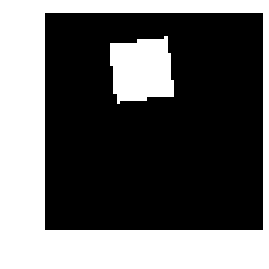

In [694]:
# testing scm works
ox, y = get_specific_data(cuda=True)
mu, sigma = vae.encoder.forward(ox,vae.remap_y(y))
scm = SCM(vae, mu.cpu(), sigma.cpu())
print(y)
plot_image(ox)

In [695]:
cond_data = {}
for i in range(1, 6):
    cond_data["Y_{}".format(i)] = torch.tensor(y[0,i].cpu()).to(torch.float32)

cond_noise = scm.update_noise_svi(cond_data)

print(cond_noise)

step 0: loss of 12714.19
step 100: loss of inf
step 200: loss of inf
step 300: loss of inf
step 400: loss of inf
step 500: loss of inf
step 600: loss of -116.89
step 700: loss of inf
step 800: loss of inf
step 900: loss of -145.18
{'N_X': Normal(loc: torch.Size([4096]), scale: torch.Size([4096])), 'N_Z': Normal(loc: torch.Size([50]), scale: torch.Size([50])), 'N_Y_1': Normal(loc: torch.Size([3]), scale: torch.Size([3])), 'N_Y_2': Normal(loc: torch.Size([6]), scale: torch.Size([6])), 'N_Y_3': Normal(loc: torch.Size([40]), scale: torch.Size([40])), 'N_Y_4': Normal(loc: torch.Size([32]), scale: torch.Size([32])), 'N_Y_5': Normal(loc: torch.Size([32]), scale: torch.Size([32]))}


In [696]:
# for noise_term, d in cond_noise.items():
#     print(noise_term, d.loc)

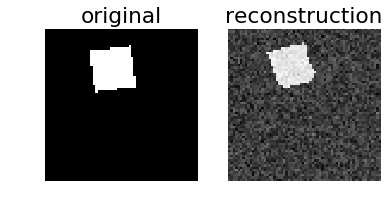

In [747]:
(rx,_,_), _ = scm.model(cond_noise)
compare_reconstruction(ox, rx)

### sanity check that do-operation should work on trained network

At one point I was concerned that the network was encoding too much information in the latent encoding z and thus conditioning on the labels wasnt enough to change the output.  According to the results below, that is not the case.  We should be able to condition on the labels and get sensible outputs from the conditioned model.

top:  tensor([[ 0.,  2.,  3.,  3., 29., 16.]], device='cuda:0')
bottom:  tensor([[ 0.,  1.,  3.,  3., 29., 16.]], device='cuda:0')


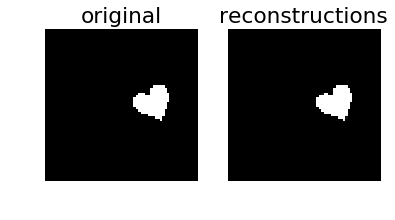

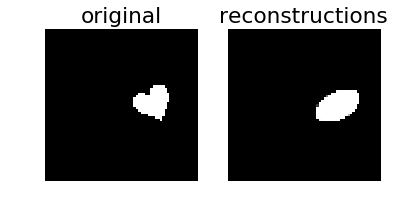

In [344]:
original, y_original = get_specific_data(cuda=True)
print('top: ',y_original)
mu, sigma = vae.encoder.forward(original,vae.remap_y(y_original))
B = 100
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_original) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)

y_new = torch.tensor(y_original)
y_new[0,1] = (y_original[0,1] + 1) % 2
print('bottom: ', y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)
